In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspellchecker
!pip install py-readability-metrics
!pip install textstat
!pip install pyarrow
!pip install transformers
!pip install tqdm
!pip install datasets
!pip install tensorflow
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires

In [29]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import torch

import textstat
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from spellchecker import SpellChecker
from readability import Readability

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import TFAutoModelForSequenceClassification

from datasets import Dataset

from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, ndcg_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import skew, kurtosis

import gc
from tqdm import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read Few-shot categorization data

In [51]:
## read yelp_dataset_for_model.csv
chunk_size = 100000

# Initialize an empty DataFrame to concatenate chunks
yelp_data_full = pd.DataFrame()

# Read CSV in chunks
with pd.read_csv('/content/drive/MyDrive/Code + Data/yelp_dataset_for_model_few_shot_final.csv', chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
        yelp_data_full = pd.concat([yelp_data_full, chunk], ignore_index=True)
        del chunk
        gc.collect()

        if (i + 1) % 5 == 0:
            print(f'Progress: {(i + 1) * chunk_size} rows processed')

Progress: 500000 rows processed


<ipython-input-51-4bf63aeebe3c>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):
<ipython-input-51-4bf63aeebe3c>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Progress: 1000000 rows processed
Progress: 1500000 rows processed


<ipython-input-51-4bf63aeebe3c>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


In [52]:
print(len(yelp_data_full))
yelp_data = yelp_data_full
del yelp_data_full

1872289


# Drop non-english reviews

In [53]:
print(yelp_data.shape)

(1872289, 16)


In [54]:

non_english_ids = pd.read_csv("/content/drive/MyDrive/Code + Data/non_english_ids.csv")
# Check rows before drop
print(f'There are {yelp_data.shape[0]} rows before dropping')
# Create a boolean mask
mask = ~yelp_data['review_id'].isin(non_english_ids['review_id'])
# Drop the rows
yelp_data = yelp_data[mask]
# Check rows after drop
print(f'There are {yelp_data.shape[0]} rows after dropping')

There are 1872289 rows before dropping
There are 1870042 rows after dropping


In [55]:
print(yelp_data.shape)

(1870042, 16)


In [56]:
print(yelp_data.columns)

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'num_characters', 'num_words', 'review_type'],
      dtype='object')


In [57]:
yelp_data['helpful'].describe()

,helpful
count,1.870042e+06
mean,1.471494e-03
std,4.250018e-03
min,-2.832861e-03
25%,0.000000e+00
50%,0.000000e+00
75%,1.666667e-03
max,3.808463e-01


In [58]:
print("Skewness:", skew(yelp_data['helpful']))
print("Kurtosis:", kurtosis(yelp_data['helpful']))

Skewness: 16.819048553537687
Kurtosis: 695.4625859691812


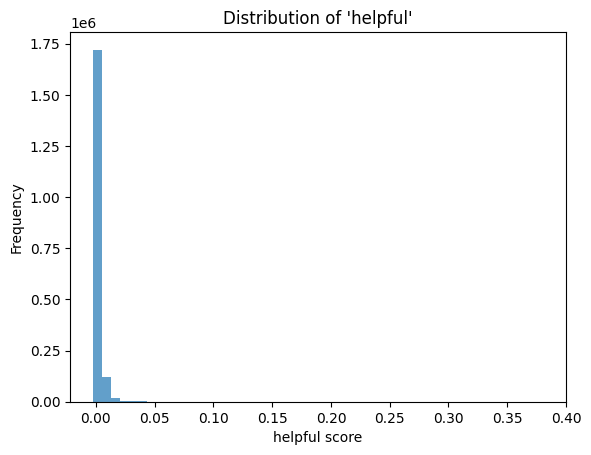

In [59]:
plt.hist(yelp_data['helpful'], bins=50, alpha=0.7)
plt.title("Distribution of 'helpful'")
plt.xlabel("helpful score")
plt.ylabel("Frequency")
plt.show()

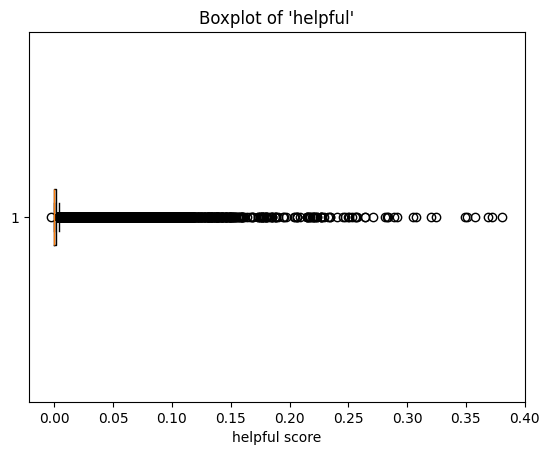

In [60]:
plt.boxplot(yelp_data['helpful'], vert=False)
plt.title("Boxplot of 'helpful'")
plt.xlabel("helpful score")
plt.show()


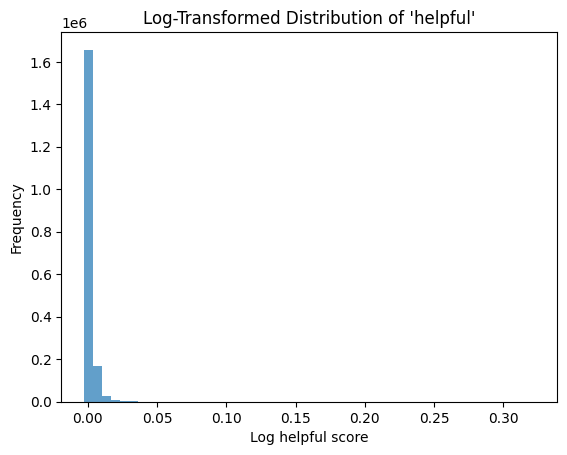

In [61]:
yelp_data['helpful_log'] = np.log1p(yelp_data['helpful'])
plt.hist(yelp_data['helpful_log'], bins=50, alpha=0.7)
plt.title("Log-Transformed Distribution of 'helpful'")
plt.xlabel("Log helpful score")
plt.ylabel("Frequency")
plt.show()

In [39]:
helpful = yelp_data['helpful'].values.reshape(-1, 1)

# Apply Min-Max Scaling
scaler = MinMaxScaler()
yelp_data['helpful_normalized'] = scaler.fit_transform(helpful)

# Check the normalized values
print(yelp_data[['helpful', 'helpful_normalized']].describe())

            helpful  helpful_normalized
count  1.870042e+06        1.870042e+06
mean   1.471494e-03        1.121863e-02
std    4.250018e-03        1.107701e-02
min   -2.832861e-03        0.000000e+00
25%    0.000000e+00        7.383411e-03
50%    0.000000e+00        7.383411e-03
75%    1.666667e-03        1.172732e-02
max    3.808463e-01        1.000000e+00


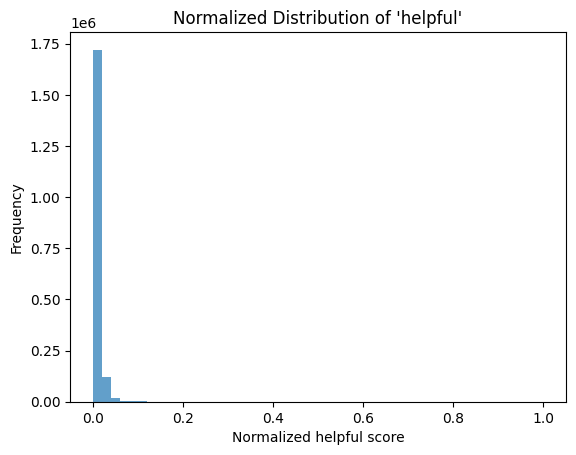

In [40]:
plt.hist(yelp_data['helpful_normalized'], bins=50, alpha=0.7)
plt.title("Normalized Distribution of 'helpful'")
plt.xlabel("Normalized helpful score")
plt.ylabel("Frequency")
plt.show()

# Downsample helpful=0 reviews


In [62]:
print(f"Original dataset size: {len(yelp_data)}")
print("0 helpful reviews", len(yelp_data[yelp_data['helpful'] == 0]))
minority_count = len(yelp_data[yelp_data['helpful'] > 0])
print(f"helpful > 0 reviews: {minority_count}")

Original dataset size: 1870042
0 helpful reviews 1147389
helpful > 0 reviews: 722652


In [63]:
majority_class = yelp_data[yelp_data['helpful'] == 0]
minority_class = yelp_data[yelp_data['helpful'] > 0]

minority_count = len(minority_class)
target_majority_size = int(minority_count)  # Keep 1x as many majority class reviews; ~280k

# Downsample the majority class
downsampled_majority = majority_class.sample(n=target_majority_size, random_state=42)

balanced_data = pd.concat([downsampled_majority, minority_class])

# Shuffle
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

yelp_data = balanced_data

In [64]:
yelp_data.shape

(1445304, 17)

In [65]:
print(f"dataset size: {len(yelp_data)}")
print("0 helpful reviews", len(yelp_data[yelp_data['helpful'] == 0]))
minority_count = len(yelp_data[yelp_data['helpful'] > 0])
print(f"helpful > 0 reviews: {minority_count}")

dataset size: 1445304
0 helpful reviews 722652
helpful > 0 reviews: 722652


# Models with Few-shot categorization

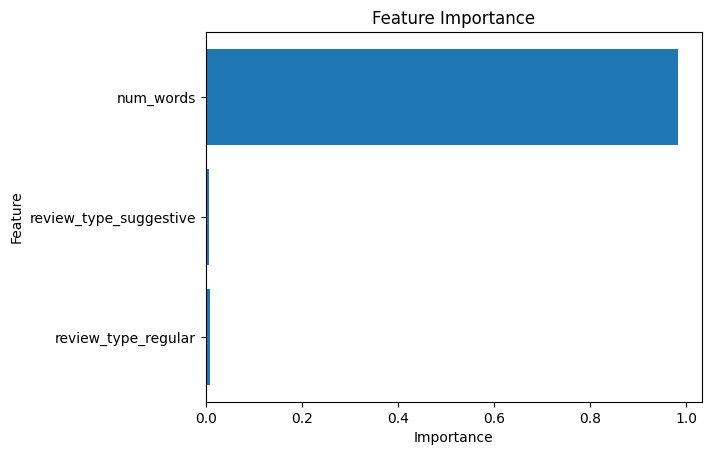

In [46]:
feature_importances = model.feature_importances_
feature_names = encoder.get_feature_names_out(['review_type']).tolist() + ['num_words']

# Plot feature importance
plt.barh(feature_names, feature_importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

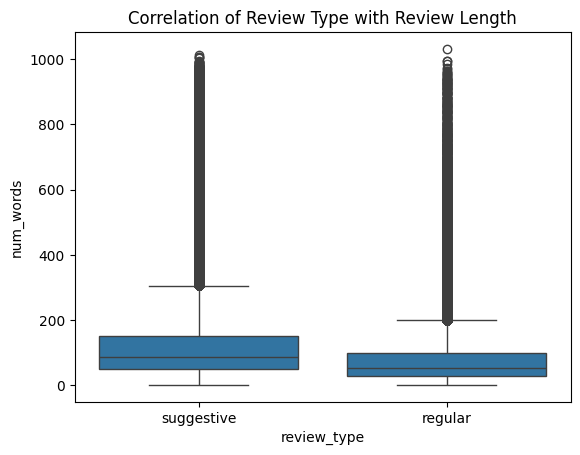

In [48]:
sns.boxplot(x='review_type', y='num_words', data=balanced_data)
plt.title("Correlation of Review Type with Review Length")
plt.show()

In [67]:
encoder = OneHotEncoder(sparse_output=False)
review_type_encoded = encoder.fit_transform(yelp_data[['review_type']])

encoded_cols = pd.DataFrame(review_type_encoded, columns=encoder.get_feature_names_out(['review_type']))
yelp_data = pd.concat([yelp_data.reset_index(drop=True), encoded_cols.reset_index(drop=True)], axis=1)

yelp_data['length_effect'] = yelp_data.apply(
    lambda row: row['num_words'] if row['review_type'] == 'regular' else
                row['num_words'] * 1.5 if row['review_type'] == 'comparative' else
                row['num_words'] * -0.5,
    axis=1
)

# scaler = MinMaxScaler()
# yelp_data['helpful_normalized'] = scaler.fit_transform(yelp_data[['helpful']])
# yelp_data[['num_words', 'length_effect']] = scaler.fit_transform(yelp_data[['num_words', 'length_effect']])

# X = yelp_data[['num_words', 'length_effect'] + list(encoded_cols.columns)]
# y = yelp_data['helpful_normalized']

yelp_data['helpful_log'] = np.log1p(yelp_data['helpful'])
yelp_data['num_words_log'] = np.log1p(yelp_data['num_words'])
print(yelp_data['helpful_log'].describe())

X = yelp_data[['num_words_log', 'length_effect'] + list(encoded_cols.columns)]
y = yelp_data['helpful_log']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count    1.445304e+06
mean     1.891373e-03
std      4.587784e-03
min      0.000000e+00
25%      0.000000e+00
50%      7.515971e-05
75%      2.285715e-03
max      3.226966e-01
Name: helpful_log, dtype: float64


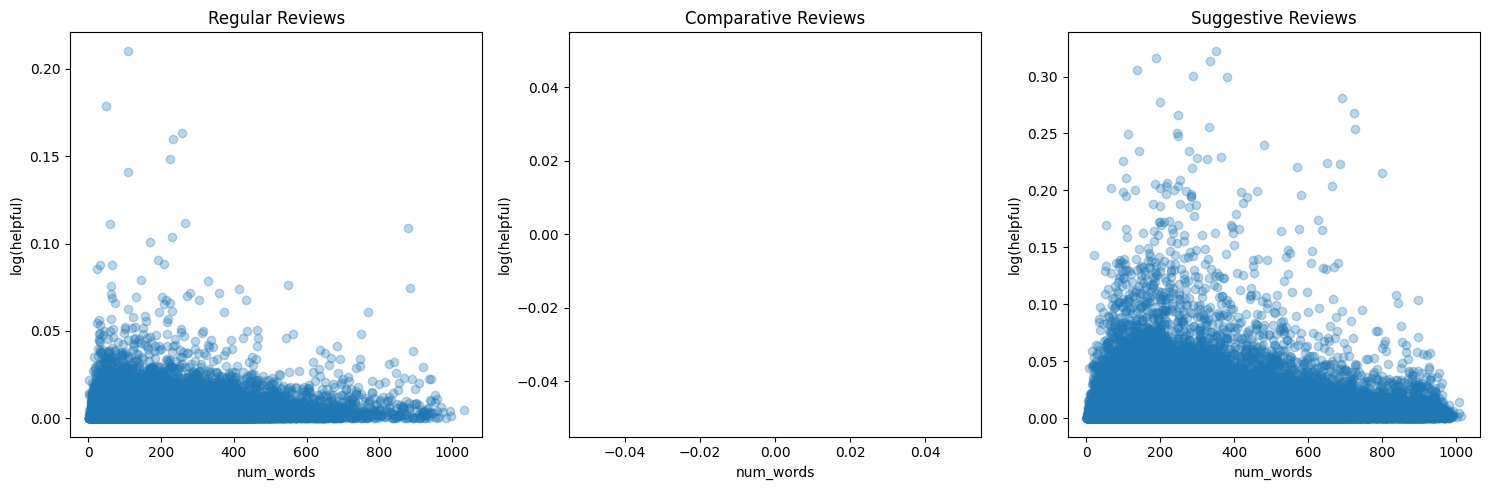

In [68]:
plt.figure(figsize=(15, 5))

review_types = ['regular', 'comparative', 'suggestive']

for i, review_type in enumerate(review_types, 1):
    plt.subplot(1, 3, i)  # Create a subplot for each review type
    subset = yelp_data[yelp_data['review_type'] == review_type]
    plt.scatter(subset['num_words'], subset['helpful_log'], alpha=0.3)
    plt.title(f"{review_type.capitalize()} Reviews")
    plt.xlabel("num_words")
    plt.ylabel("log(helpful)")
    plt.tight_layout()

plt.show()


Random Forest

In [69]:
## Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R2 Score: {rf_r2}")

y_pred_original = np.expm1(rf_pred)  # Reverse log transformation for predictions
y_test_original = np.expm1(y_test)  # Reverse log transformation for actuals

# Step 10: Evaluate the model on the original scale
original_mse = mean_squared_error(y_test_original, y_pred_original)
original_r2 = r2_score(y_test_original, y_pred_original)

print("\nRandom Forest Results (Original Scale):")
print(f"Mean Squared Error (Original Scale): {original_mse}")
print(f"R2 Score (Original Scale): {original_r2}")

Random Forest Results:
Mean Squared Error: 1.9321645112848835e-05
R2 Score: 0.06843071385324084

Random Forest Results (Original Scale):
Mean Squared Error (Original Scale): 2.0730997062120035e-05
R2 Score (Original Scale): 0.06551771272314977


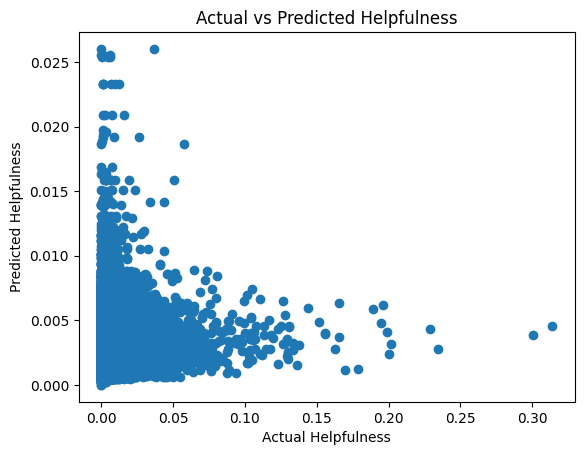

In [70]:
plt.scatter(y_test, rf_pred)
plt.xlabel("Actual Helpfulness")
plt.ylabel("Predicted Helpfulness")
plt.title("Actual vs Predicted Helpfulness")
plt.show()

Linear Regression

In [71]:
## Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate Linear Regression
lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("\nLinear Regression Results:")
print(f"Mean Squared Error: {lr_mse}")
print(f"R2 Score: {lr_r2}")


Linear Regression Results:
Mean Squared Error: 1.9335975956391874e-05
R2 Score: 0.06773976990870112


# Model with Zero-Shot Review Types

In [ ]:
## read yelp_dataset_for_model.csv
chunk_size = 100000

# Initialize an empty DataFrame to concatenate chunks
yelp_data_full = pd.DataFrame()

# Read CSV in chunks
with pd.read_csv('/content/drive/MyDrive/Code + Data/yelp_dataset_for_model_no_shot_final.csv', chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
        yelp_data_full = pd.concat([yelp_data_full, chunk], ignore_index=True)
        del chunk
        gc.collect()

        if (i + 1) % 5 == 0:
            print(f'Progress: {(i + 1) * chunk_size} rows processed')

Progress: 500000 rows processed


<ipython-input-72-41b0e6274c12>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):
<ipython-input-72-41b0e6274c12>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Progress: 1000000 rows processed


In [ ]:
# drop non-english reviews
non_english_ids = pd.read_csv("/content/drive/MyDrive/Code + Data/non_english_ids.csv")
# Check rows before drop
print(f'There are {yelp_data.shape[0]} rows before dropping')
# Create a boolean mask
mask = ~yelp_data['review_id'].isin(non_english_ids['review_id'])
# Drop the rows
yelp_data = yelp_data[mask]
# Check rows after drop
print(f'There are {yelp_data.shape[0]} rows after dropping')

In [ ]:
yelp_data_no_shot = yelp_data

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
review_type_encoded = encoder.fit_transform(yelp_data_no_shot[['review_type']])

encoded_cols = pd.DataFrame(review_type_encoded, columns=encoder.get_feature_names_out(['review_type']))
yelp_data_no_shot = pd.concat([yelp_data_no_shot.reset_index(drop=True), encoded_cols.reset_index(drop=True)], axis=1)

yelp_data_no_shot['length_effect'] = yelp_data_no_shot.apply(
    lambda row: row['num_words'] if row['review_type'] == 'regular' else
                row['num_words'] * 1.5 if row['review_type'] == 'comparative' else
                row['num_words'] * -0.5,
    axis=1
)

scaler = MinMaxScaler()
yelp_data_no_shot['helpful_normalized'] = scaler.fit_transform(yelp_data_no_shot[['helpful']])
yelp_data_no_shot[['num_words', 'length_effect']] = scaler.fit_transform(yelp_data_no_shot[['num_words', 'length_effect']])

X = yelp_data_no_shot[['num_words', 'length_effect'] + list(encoded_cols.columns)]
y = yelp_data_no_shot['helpful_normalized']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R2 Score: {rf_r2}")

Random Forest Results:
Mean Squared Error: 0.00011697487023133233
R2 Score: 0.06076784422706272


# NDCG Scores